# Hyperparameters and Model Validation

adapted from: 

*   https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.03-Hyperparameters-and-Model-Validation.ipynb

*   https://scikit-learn.org/stable/modules/learning_curve.html





### Validation curves in Scikit-Learn

Let's look at an example of using cross-validation to compute the validation curve for a class of models.
Here we will use a *polynomial regression* model: this is a generalized linear model in which the degree of the polynomial is a tunable parameter.
For example, a degree-1 polynomial fits a straight line to the data; for model parameters $a$ and $b$:

$$
y = ax + b
$$

A degree-3 polynomial fits a cubic curve to the data; for model parameters $a, b, c, d$:

$$
y = ax^3 + bx^2 + cx + d
$$

We can generalize this to any number of polynomial features.
In Scikit-Learn, we can implement this with a simple linear regression combined with the polynomial preprocessor.
We will use a *pipeline* to string these operations together (we will discuss polynomial features and pipelines more fully in [Feature Engineering](05.04-Feature-Engineering.ipynb)):

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

Now let's create some data to which we will fit our model:

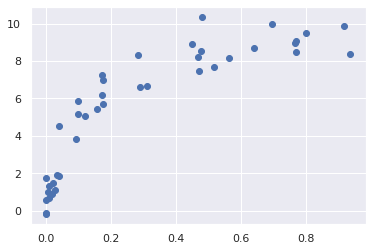

In [ ]:
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)
plt.scatter(X, y);

We can now visualize our data, along with polynomial fits of several degrees:

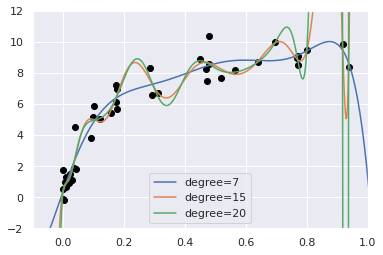

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot formatting

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [7, 15, 20]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

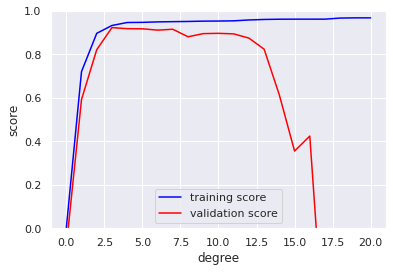

In [ ]:
from sklearn.model_selection import validation_curve

degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

This shows precisely the qualitative behavior we expect: the training score is everywhere higher than the validation score; the training score is monotonically improving with increased model complexity; and the validation score reaches a maximum before dropping off as the model becomes over-fit.



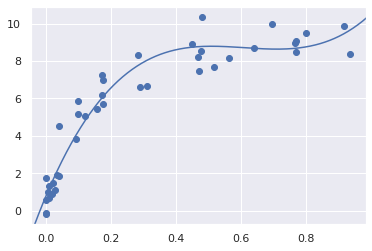

In [ ]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

Notice that finding this optimal model did not actually require us to compute the training score, but examining the relationship between the training score and validation score can give us useful insight into the performance of the model.

## Learning Curves

One important aspect of model complexity is that the optimal model will generally depend on the size of your training data.
For example, let's generate a new dataset with a factor of five more points:

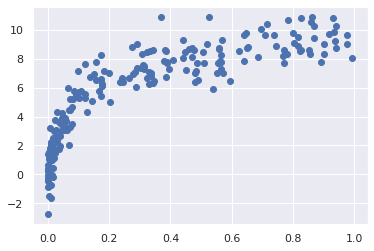

In [ ]:
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

We will duplicate the preceding code to plot the validation curve for this larger dataset; for reference let's over-plot the previous results as well:

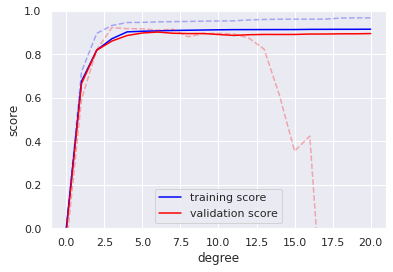

In [ ]:
X2, y2 = make_data(200)
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
                                            'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

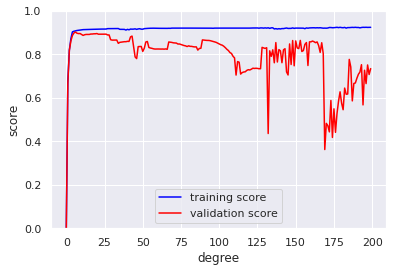

In [ ]:
X2, y2 = make_data(200)

degree = np.arange(200)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
                                            'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');


The solid lines show the new results, while the fainter dashed lines show the results of the previous smaller dataset.
It is clear from the validation curve that the larger dataset can support a much more complicated model: the peak here is probably around a degree of 6, but even a degree-20 model is not seriously over-fitting the data—the validation and training scores remain very close.

Thus we see that the behavior of the validation curve has not one but two important inputs: the model complexity and the number of training points.
